In [1]:
import CairoMakie
import CSV
import HDF5
import FASTX
import Infernal
import KernelDensity
import Makie
import RestrictedBoltzmannMachines as RBMs
import Rfam
import SamApp
import StatsBase
import PythonPlot
import Logomaker
using BioSequences: LongRNA
using DataFrames: DataFrame
using Distributions: Gamma
using Distributions: logpdf
using Distributions: pdf
using Distributions: Poisson
using LinearAlgebra: Diagonal
using LinearAlgebra: eigen
using Makie: @L_str
using NaNStatistics: nansum
using ProgressMeter: @showprogress
using Random: bitrand
using Statistics: cor
using Statistics: mean
using StatsBase: countmap

In [2]:
# CM model from Rfam (this has the noisy floor!)
Rfam_cm = Infernal.cmfetch(Rfam.cm(), "RF00162");

In [3]:
# trimmed (no inserts) aligned fasta
RF00162_hits_afa = Infernal.cmalign(Rfam_cm.out, Rfam.fasta_file("RF00162"); matchonly=true, outformat="AFA");
# these are already aligned and without inserts
RF00162_hits_sequences = FASTX.sequence.(FASTX.FASTA.Reader(open(RF00162_hits_afa.out)));
@assert only(unique(length.(RF00162_hits_sequences))) == 108
RF00162_hits_sequences = LongRNA{4}.(RF00162_hits_sequences);

# Plots

In [4]:
# APC-corrected contact map
Cmap = SamApp.effective_contacts(SamApp.rbm2022(), SamApp.onehot(RF00162_hits_sequences));

# zero-out diagonal
for i in axes(Cmap, 1)
    Cmap[i,i] = 0
end

In [5]:
# plotted_matrix_lo = (Cmap .- minimum(Cmap)) ./ (maximum(Cmap) .- minimum(Cmap));
# plotted_matrix_hi = (cors_sq_hits .- minimum(cors_sq_hits)) ./ (maximum(cors_sq_hits) .- minimum(cors_sq_hits));

plotted_matrix = copy(Cmap)
for i = axes(plotted_matrix, 1), j = axes(plotted_matrix, 2)
    if i < j
        plotted_matrix[i,j] = Cmap[i,j]
    else
        plotted_matrix[i,j] = 0
    end
end

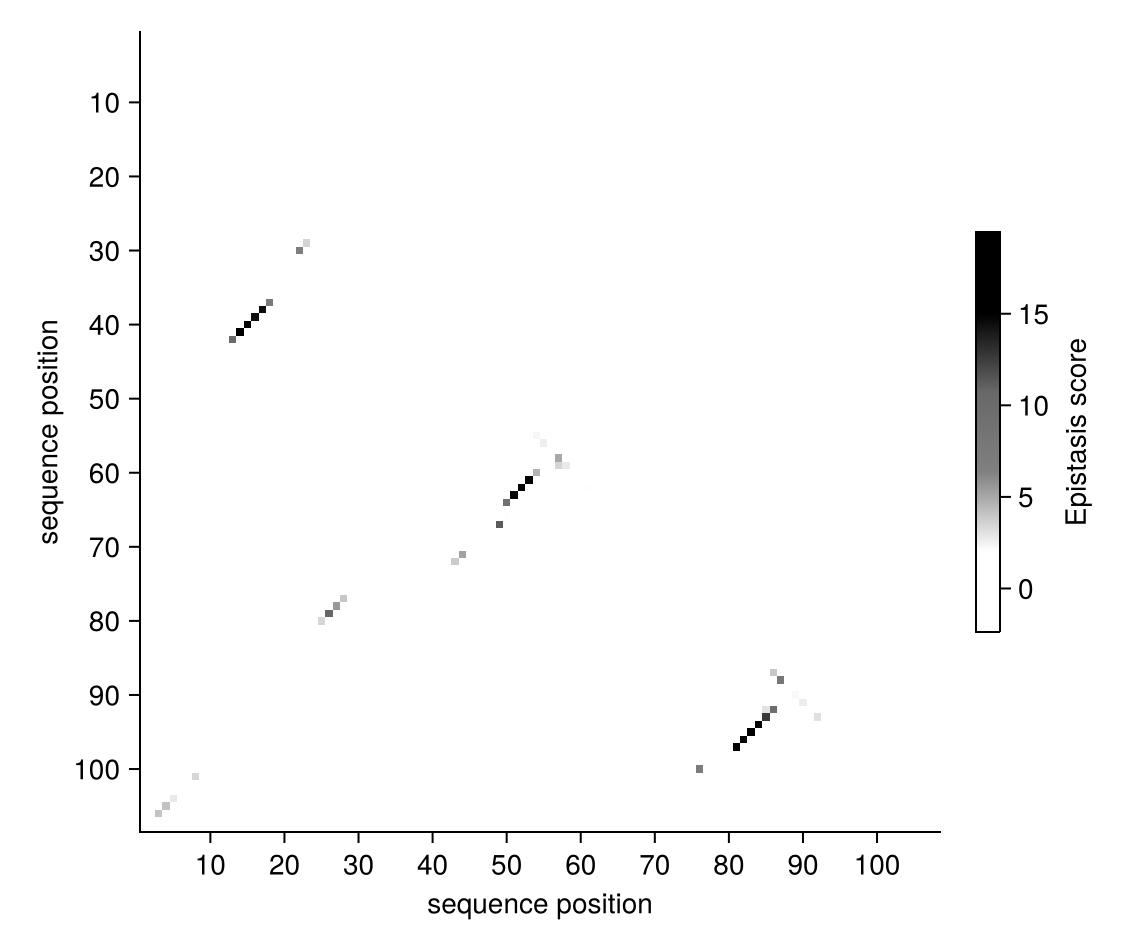

In [6]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], yreversed=true, width=400, height=400, xticks=0:10:size(Cmap,1), yticks=0:10:size(Cmap,2), xlabel="sequence position", ylabel="sequence position")
hm = Makie.heatmap!(ax, plotted_matrix, colormap=["white", "white", "gray", "dimgray", "black", "black"])
Makie.hidespines!(ax, :t, :r)
Makie.Colorbar(fig[1,2], hm, height=200, label="Epistasis score")
Makie.resize_to_layout!(fig)
Makie.save("Figures/Contacts bw.pdf", fig)
fig

In [11]:
plotted_matrix[1,2]

0.49895155f0

In [18]:
plotted_matrix[14,41]

19.169228f0

In [20]:
epistasis_scores_flat = [plotted_matrix[i,j] for i = axes(plotted_matrix, 1) for j = axes(plotted_matrix, 2) if i < j];
_p = sortperm(epistasis_scores_flat; rev=true)
df = DataFrame(; 
    site1 = [i for i = axes(plotted_matrix, 1) for j = axes(plotted_matrix, 2) if i < j][_p],
    site2 = [j for i = axes(plotted_matrix, 1) for j = axes(plotted_matrix, 2) if i < j][_p],
    score = epistasis_scores_flat[_p]
)
CSV.write("/workspaces/SamApp.jl/data/Epistasis_Scores.csv", df)
df

Row,site1,site2,score
,Int64,Int64,Float32
1,52,62,19.4629
2,14,41,19.1692
3,84,94,18.7603
4,51,63,17.0271
5,81,97,16.434
6,15,40,15.7126
7,83,95,15.7085
8,53,61,15.5062
9,82,96,14.7465


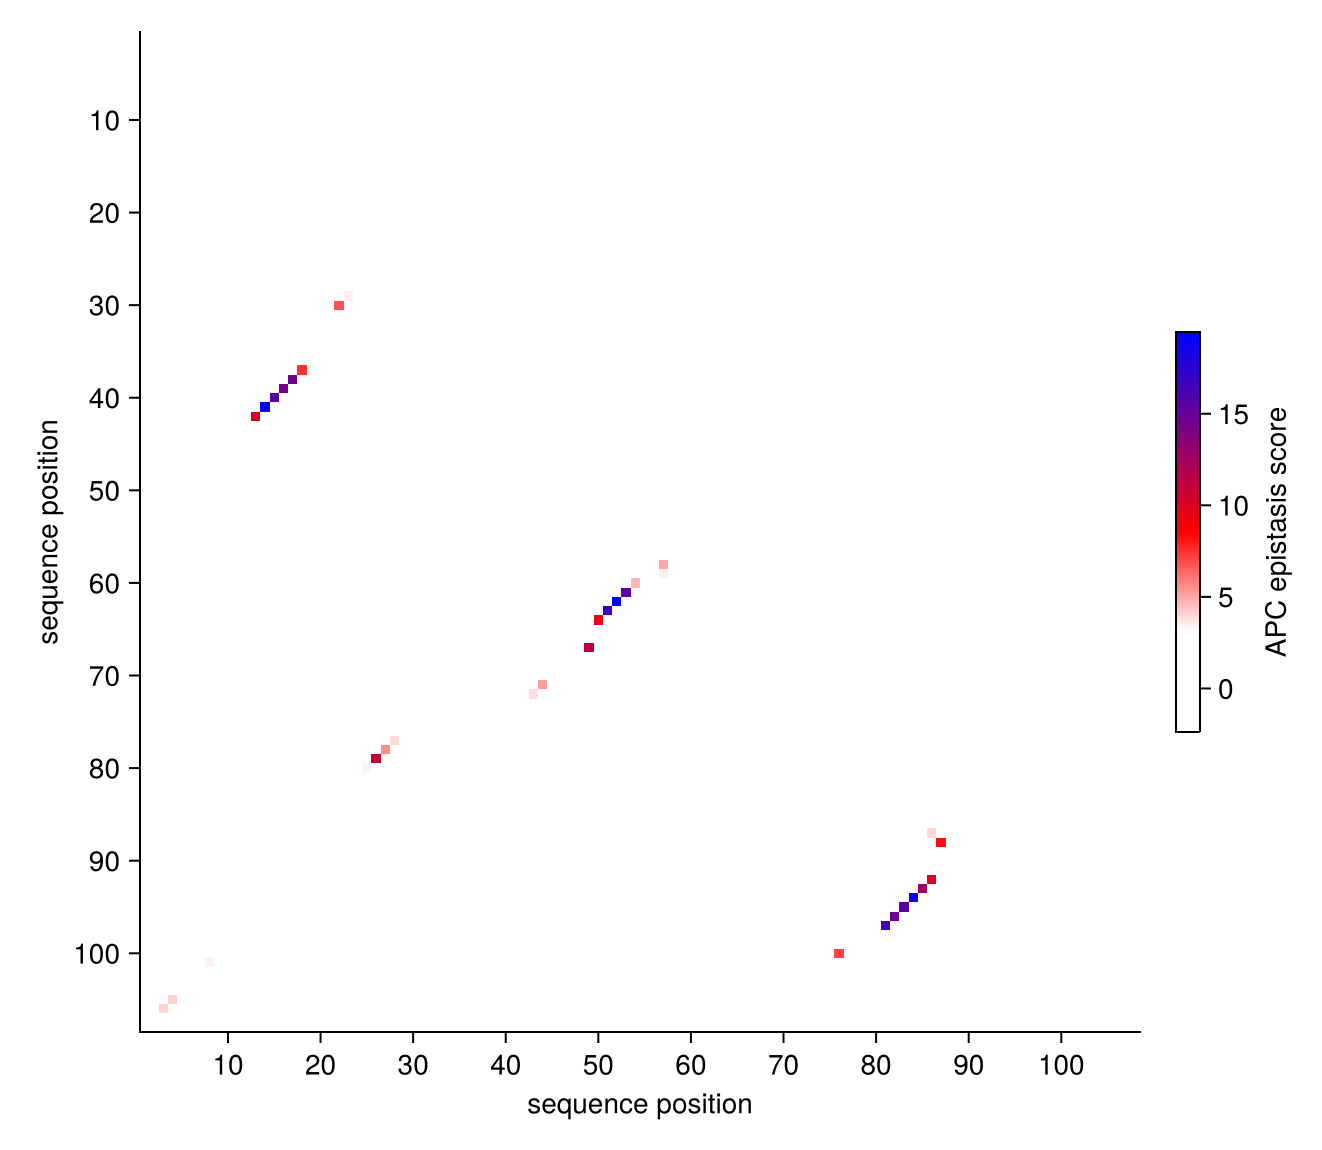

In [ ]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], yreversed=true, width=500, height=500, xticks=0:10:size(Cmap,1), yticks=0:10:size(Cmap,2), xlabel="sequence position", ylabel="sequence position")
hm = Makie.heatmap!(ax, plotted_matrix, colormap=["white", "white", "red", "purple", "blue"])
Makie.hidespines!(ax, :t, :r)
Makie.Colorbar(fig[1,2], hm, height=200, label="APC epistasis score")
Makie.resize_to_layout!(fig)
#Makie.save("Figures/Generation and contacts.pdf", fig)
fig

In [14]:
struct_bands = [
    (; x0=0.5, xf=8.5, color="blue", alpha=0.1), # P1
    (; x0=100.5, xf=108.5, color="blue", alpha=0.1), # P1
    (; x0=11.5, xf=16.5, color="green", alpha=0.1), # P2
    (; x0=20.5, xf=23.5, color="green", alpha=0.1), # P2
    (; x0=28.5, xf=31.5, color="green", alpha=0.1), # P2
    (; x0=37.5, xf=42.5, color="green", alpha=0.1), # P2
    (; x0=42.5, xf=46.5, color="orange", alpha=0.1), # P3
    (; x0=47.5, xf=53.5, color="orange", alpha=0.1), # P3
    (; x0=60.5, xf=64.5, color="orange", alpha=0.1), # P3
    (; x0=66.5, xf=72.5, color="orange", alpha=0.1), # P3
    (; x0=80.5, xf=86.5, color="teal", alpha=0.1), # P4
    (; x0=91.5, xf=97.5, color="teal", alpha=0.1), # P4
]

12-element Vector{@NamedTuple{x0::Float64, xf::Float64, color::String, alpha::Float64}}:
 (x0 = 0.5, xf = 8.5, color = "blue", alpha = 0.1)
 (x0 = 100.5, xf = 108.5, color = "blue", alpha = 0.1)
 (x0 = 11.5, xf = 16.5, color = "green", alpha = 0.1)
 (x0 = 20.5, xf = 23.5, color = "green", alpha = 0.1)
 (x0 = 28.5, xf = 31.5, color = "green", alpha = 0.1)
 (x0 = 37.5, xf = 42.5, color = "green", alpha = 0.1)
 (x0 = 42.5, xf = 46.5, color = "orange", alpha = 0.1)
 (x0 = 47.5, xf = 53.5, color = "orange", alpha = 0.1)
 (x0 = 60.5, xf = 64.5, color = "orange", alpha = 0.1)
 (x0 = 66.5, xf = 72.5, color = "orange", alpha = 0.1)
 (x0 = 80.5, xf = 86.5, color = "teal", alpha = 0.1)
 (x0 = 91.5, xf = 97.5, color = "teal", alpha = 0.1)

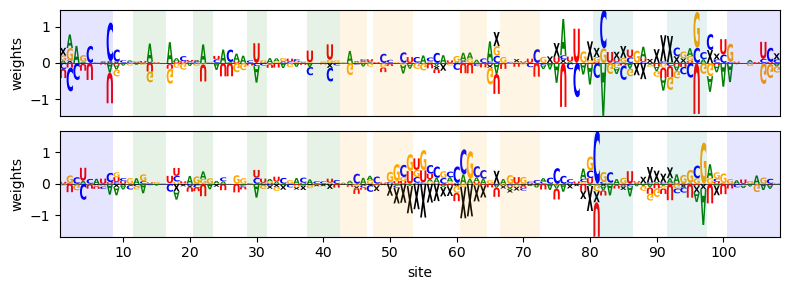

In [84]:
#=
2024-03-23. For some reason I can't get the gap character '⊟' to work here in Jupyter.
But it works if I just run a Julia script (HUs.jl), so use that instead to make this plot.
=#

fig, ax = PythonPlot.subplots(2, 1, figsize=[8, 3])

ax = PythonPlot.subplot(2, 1, 1)
for (; x0, xf, color, alpha) = struct_bands
    ax.axvspan(x0, xf; alpha, color, linewidth=0)
end
logo = Logomaker.Logo(SamApp.rbm2022().w[:,:,44], collect("ACGUX"); color_scheme="classic", ax)
#logo = SamApp.seqlogo_fields(SamApp.rbm2022().w[:,:,44]; gapchar='X')
#ax.set_xticks(10:10:108)
ax.set_xticks(Int[], Int[])
ax.set_yticks(-1:1)
ax.set_ylabel("weights")
ax.set_xlim(0.5, 108.5)

ax = PythonPlot.subplot(2, 1, 2)
for (; x0, xf, color, alpha) = struct_bands
    ax.axvspan(x0, xf; alpha, color, linewidth=0)
end
logo = Logomaker.Logo(SamApp.rbm2022().w[:,:,67], collect("ACGUX"); color_scheme="classic", ax)
#logo = SamApp.seqlogo_fields(SamApp.rbm2022().w[:,:,44]; gapchar='X')
ax.set_xticks(10:10:108)
ax.set_yticks(-1:1)
ax.set_xlabel("site")
ax.set_ylabel("weights")
ax.set_xlim(0.5, 108.5)

PythonPlot.tight_layout()
#fig.savefig("Figures/Hidden unit weights.pdf", bbox_inches="tight")
fig

In [ ]:
import os
import locale
os.environ["PYTHONIOENCODING"] = "utf-8"

In [31]:
map(string, collect("ACGU#"))

5-element Vector{String}:
 "A"
 "C"
 "G"
 "U"
 "#"

In [34]:
fig, ax = PythonPlot.subplots(2, 1, figsize=[8, 3])

ax = PythonPlot.subplot(2, 1, 1)
for (; x0, xf, color, alpha) = struct_bands
    ax.axvspan(x0, xf; alpha, color, linewidth=0)
end
logo = Logomaker.Logo(SamApp.rbm2022().w[:,:,44], collect("ACGUX"); color_scheme="classic", ax)
#logo = SamApp.seqlogo_fields(SamApp.rbm2022().w[:,:,44]; gapchar='X')
#ax.set_xticks(10:10:108)
ax.set_xticks(Int[], Int[])
ax.set_yticks(-1:1)
ax.set_ylabel("weights")
ax.set_xlim(0.5, 108.5)

ax = PythonPlot.subplot(2, 1, 2)
for (; x0, xf, color, alpha) = struct_bands
    ax.axvspan(x0, xf; alpha, color, linewidth=0)
end
logo = Logomaker.Logo(SamApp.rbm2022().w[:,:,67], collect("ACGU⊟"); color_scheme="classic", ax)
#logo = SamApp.seqlogo_fields(SamApp.rbm2022().w[:,:,44]; gapchar='X')
ax.set_xticks(10:10:108)
ax.set_yticks(-1:1)
ax.set_xlabel("site")
ax.set_ylabel("weights")
ax.set_xlim(0.5, 108.5)

PythonPlot.tight_layout()
fig.savefig("Figures/Hidden unit weights.pdf", bbox_inches="tight")
#fig

PythonCall.Core.PyException: Python: UnicodeEncodeError: 'ascii' codec can't encode character '\u229f' in position 21: ordinal not in range(128)

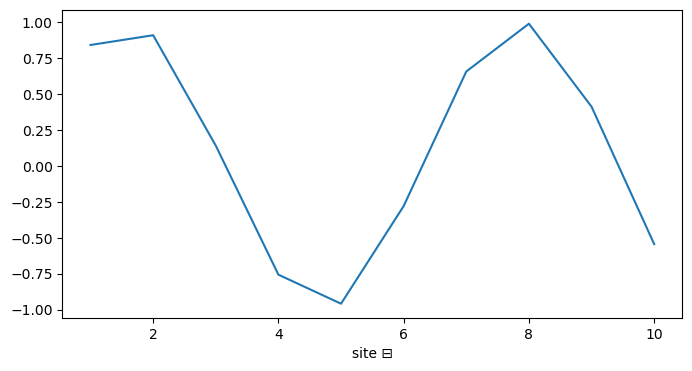

In [27]:
fig, ax = PythonPlot.subplots(1, 1, figsize=[8,4])
PythonPlot.plot(1:10, sin.(1:10))
ax.set_xlabel("site ⊟")
fig